## **Etapa 1: importando bibliotecas**
---

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from matplotlib.widgets import Slider
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

## **Etapa 2 – Carregamento da imagem e limiarização**
---
Lê a imagem do ECG manuscrito, converte para tons de cinza, aplica suavização e limiarização para isolar o traçado do sinal.

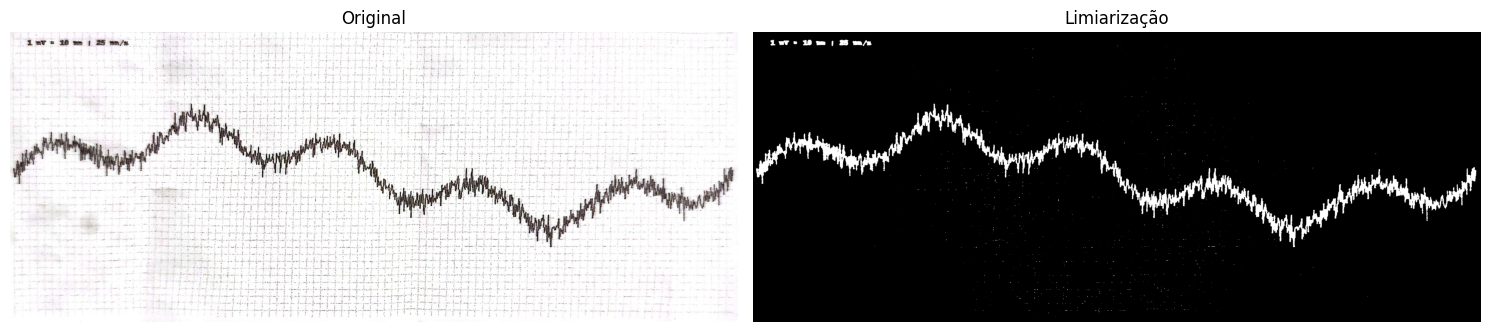

In [3]:
# Caminho da imagem 
image_path = r"C:\Users\rayla\Downloads\pds1.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Suavização para ajudar na limiarização
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#Limiarização manual (binária inversa — traçado branco)
_, binary = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY_INV)

# Visualização
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Limiarização")
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


## **Etapa 3 – Limpeza da imagem binária**
---
Elimina pequenos componentes desconectados (como grânulos da grade ou manchas) usando análise de componentes conectados, deixando apenas o traçado principal.

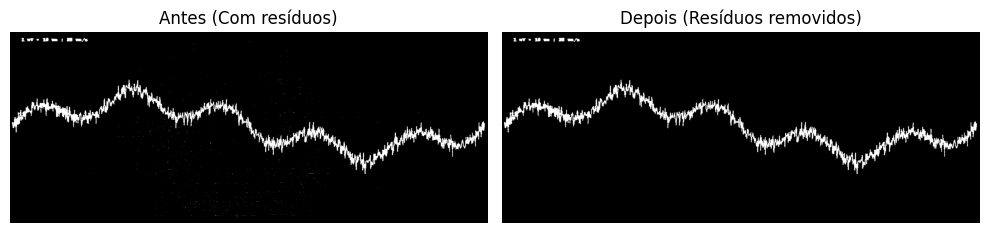

In [4]:
#Remoção de grânulos residuais da grade (componentes pequenos)

# Converte a imagem binária para formato correto
# (garante que os valores sejam 0 ou 255 inteiros)
binary_uint8 = binary.astype(np.uint8)

# Aplica connected components para encontrar áreas conectadas
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_uint8, connectivity=8)

# Cria uma imagem preta para armazenar os componentes válidos
filtered = np.zeros_like(binary_uint8)

# Define a área mínima em pixels 
area_minima = 30

# Mantém apenas os componentes com área maior ou igual à mínima
for i in range(1, num_labels):  # Ignora o fundo (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= area_minima:
        filtered[labels == i] = 255

# Visualização comparativa
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Antes (Com resíduos)")
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Depois (Resíduos removidos)")
plt.imshow(filtered, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Etapa 4 – Remoção Manual da Legenda**
---
Zera manualmente a região onde está a legenda ou anotações manuscritas na imagem, evitando interferência na reconstrução do sinal.

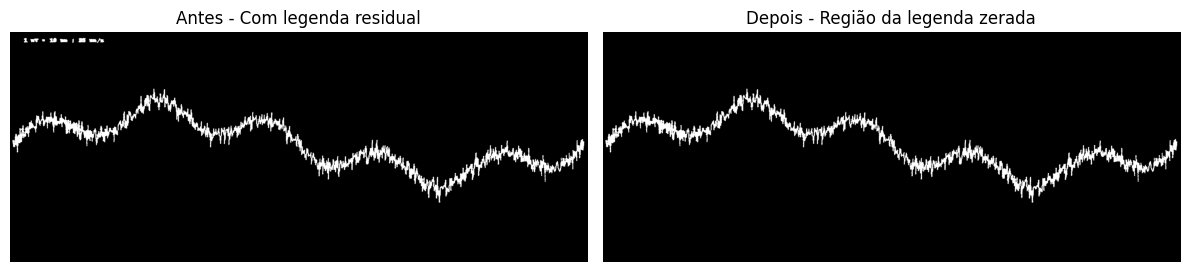

In [5]:
# Clona a imagem para teste, para não alterar o original
test_img = filtered.copy()

# Zera a região da legenda (ajuste os valores conforme necessário)
test_img[0:100, 0:700] = 0

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.title("Antes - Com legenda residual")
plt.imshow(filtered, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Depois - Região da legenda zerada")
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Etapa 5 – Medição da Escala com Sliders**
---
Cria uma interface com sliders para medir a largura de uma célula da grade em pixels, servindo como referência para converter pixels em unidades reais (tempo e amplitude).

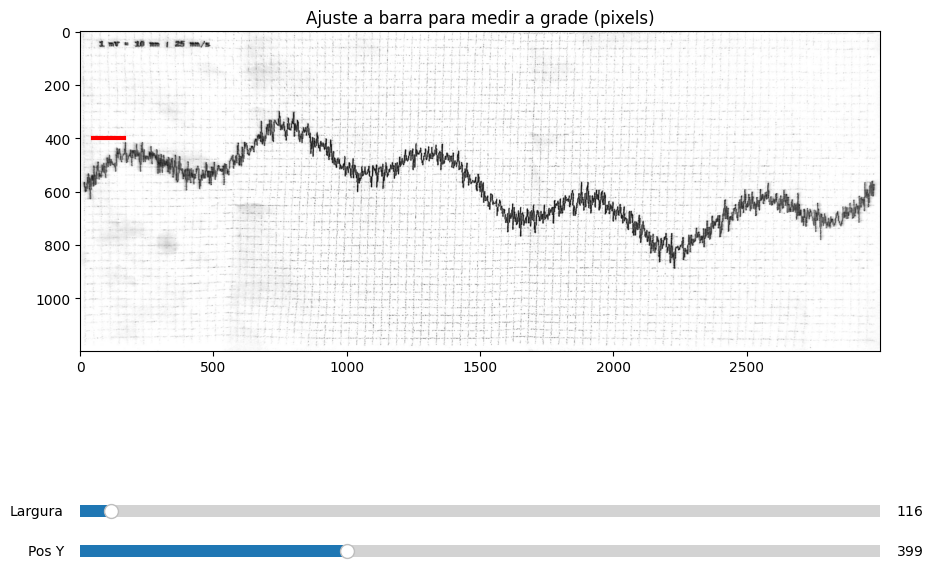

Posição vertical da barra (pixels): 399
Largura da barra (pixels): 116


In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.1, bottom=0.25)

ax.imshow(gray, cmap='gray')
ax.set_title('Ajuste a barra para medir a grade (pixels)')

# Barra inicial: posição y e largura (em pixels)
bar_y = gray.shape[0] // 3  # linha vertical central
bar_x_start = 50
bar_width = 116

# Desenha a barra horizontal inicial
bar_line, = ax.plot([bar_x_start, bar_x_start + bar_width], [bar_y, bar_y], color='red', linewidth=3)

# Eixos para sliders (posição vertical e largura)
axcolor = 'lightgoldenrodyellow'
ax_pos = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor=axcolor)
ax_width = plt.axes([0.1, 0.15, 0.8, 0.03], facecolor=axcolor)

slider_pos = Slider(ax_pos, 'Pos Y', 0, gray.shape[0]-1, valinit=bar_y, valstep=1)
slider_width = Slider(ax_width, 'Largura', 1, gray.shape[1], valinit=bar_width, valstep=1)

def update(val):
    y = slider_pos.val
    w = slider_width.val
    x_start = bar_x_start
    x_end = x_start + w
    bar_line.set_data([x_start, x_end], [y, y])
    fig.canvas.draw_idle()

slider_pos.on_changed(update)
slider_width.on_changed(update)

plt.show()

print(f'Posição vertical da barra (pixels): {slider_pos.val:.0f}')
print(f'Largura da barra (pixels): {slider_width.val:.0f}')



## **Etapa 6 – Reconstrução do Sinal ECG**
---
Extrai o traçado coluna por coluna, converte a posição vertical em milivolts (mV) e mapeia no tempo para reconstruir o sinal ECG como gráfico contínuo de amplitude vs. tempo.

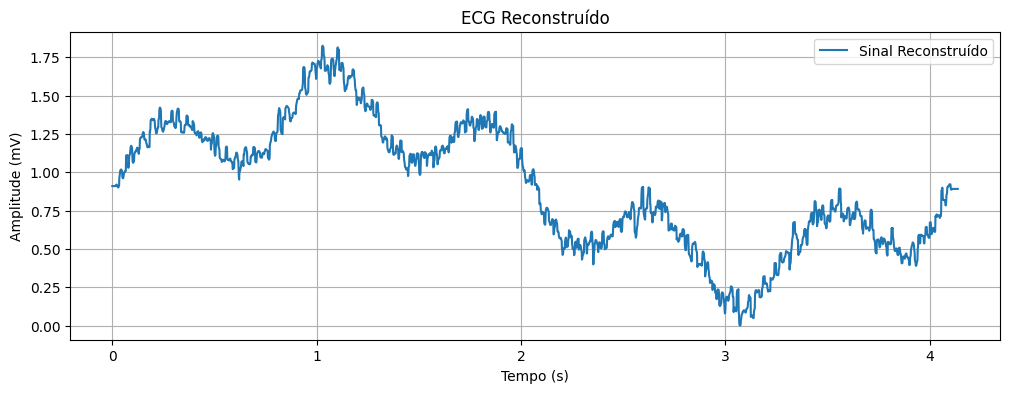

In [7]:
# Parâmetros da escala
pixels_por_mm = 29
pixels_por_mv = pixels_por_mm * 10   # 290 pixels por mV
pixels_por_s = pixels_por_mm * 25    # 725 pixels por segundo

img = filtered.copy()  # faz uma cópia da imagem binária limpa
height, width = img.shape

# Zerar a região da legenda antes de reconstruir
img[0:100, 0:700] = 0

amplitudes_pixels = []

for x in range(width):
    ys = np.where(img[:, x] > 0)[0]  # linhas onde o traçado existe nesta coluna
    if len(ys) == 0:
        amplitudes_pixels.append(np.nan)  # sinal ausente nesta coluna
    else:
        # pegar o pixel mediano para evitar outliers
        amplitudes_pixels.append(np.percentile(ys, 10))


amplitudes_pixels = np.array(amplitudes_pixels)

# Interpolação para preencher NaNs
nans, x_valid = np.isnan(amplitudes_pixels), lambda z: z.nonzero()[0]
amplitudes_pixels[nans] = np.interp(x_valid(nans), x_valid(~nans), amplitudes_pixels[~nans])

# Linha base (referência vertical): posição mais baixa (maior valor de y)
linha_base_pixels = np.max(amplitudes_pixels)

# Conversão de pixels para mV
amplitude_mV = (linha_base_pixels - amplitudes_pixels) / pixels_por_mv

# Tempo em segundos
tempo_s = np.arange(width) / pixels_por_s

# Plotagem
plt.figure(figsize=(12, 4))
plt.plot(tempo_s, amplitude_mV, label='Sinal Reconstruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.title('ECG Reconstruído')
plt.grid(True)
plt.legend()
plt.show()



## **Etapa 7 – Análise de Frequência com Transformada de Fourier**
---
A Transformada Rápida de Fourier (FFT) foi aplicada ao sinal reconstruído para identificar as componentes de frequência dominantes no ECG. Como a maior parte da energia do sinal se concentra em baixas frequências, foi utilizada também uma visualização com escala logarítmica no eixo da magnitude para facilitar a observação de componentes de menor intensidade em frequências mais altas.

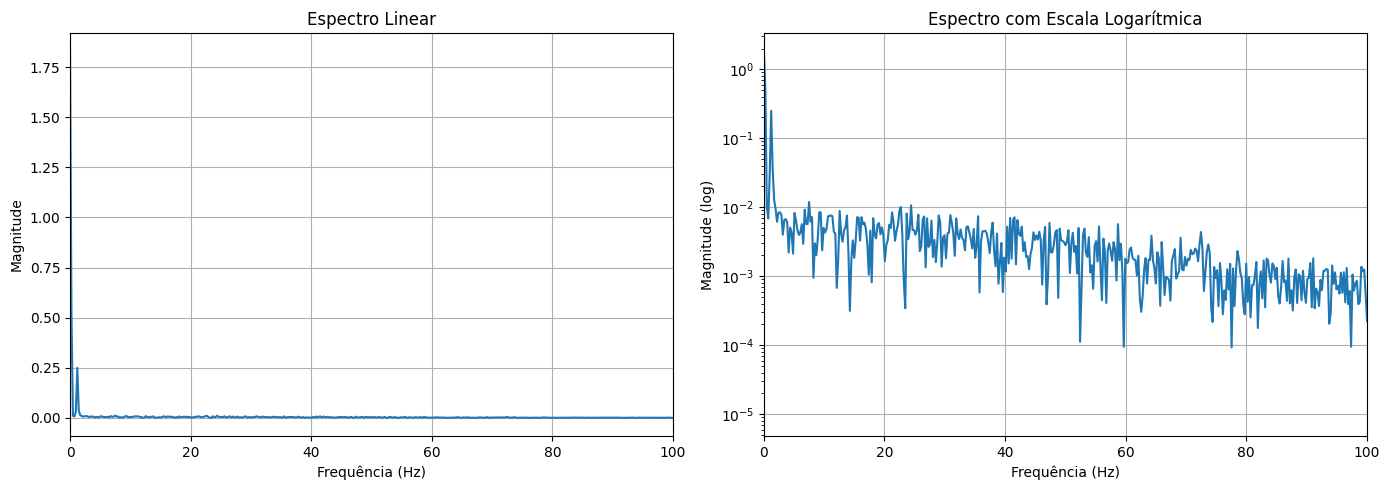

In [13]:
# Número de pontos do sinal
N = len(amplitude_mV)

# Taxa de amostragem (em Hz) — pixels por segundo!
fs = pixels_por_s  # 700 Hz no seu caso

# Transformada de Fourier
yf = fft(amplitude_mV)
xf = fftfreq(N, 1/fs)  # eixo de frequência

# Só pegar a metade positiva
xf_pos = xf[:N//2]
yf_pos = 2.0/N * np.abs(yf[:N//2])

# Figura com 2 subplots
plt.figure(figsize=(14, 5))

# Espectro linear
plt.subplot(1, 2, 1)
plt.plot(xf_pos, yf_pos)
plt.xlim(0, 100)  # Zoom opcional, ajuste se quiser
plt.title('Espectro Linear')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

# Espectro logarítmico
plt.subplot(1, 2, 2)
plt.plot(xf_pos, yf_pos)
plt.xscale('linear')
plt.yscale('log')  # Escala logarítmica no eixo Y
plt.xlim(0, 100)
plt.title('Espectro com Escala Logarítmica')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (log)')
plt.grid(True)

plt.tight_layout()
plt.show()



## **Etapa 8 – Filtragem com Filtro Butterworth Passa-Baixa**
---
Aplica um filtro digital de Butterworth passa-baixa com corte em 5 Hz para suavizar o sinal ECG reconstruído, removendo ruídos de alta frequência e preservando a morfologia das ondas cardíacas.

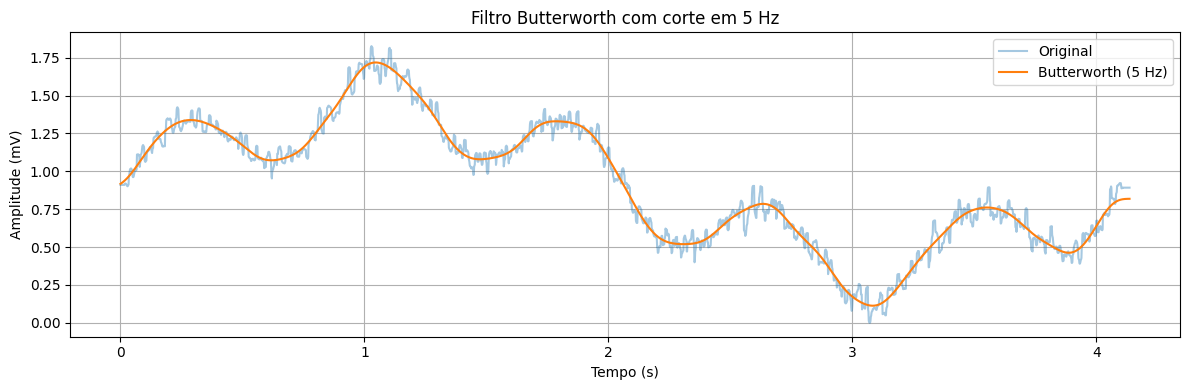

In [9]:
# Filtro Butterworth Passa-Baixa
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

fs = pixels_por_s  # taxa de amostragem em Hz (pixels/s)
cutoff = 40  # frequência de corte em Hz
sinal_butter_5hz = butter_lowpass_filter(amplitude_mV, cutoff=5, fs=fs)

sinal_filtrado = sinal_butter_5hz

plt.figure(figsize=(12, 4))
plt.plot(tempo_s, amplitude_mV, label='Original', alpha=0.4)
plt.plot(tempo_s, sinal_butter_5hz, label='Butterworth (5 Hz)', linewidth=1.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Filtro Butterworth com corte em 5 Hz')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## **Etapa 9 – Detecção dos Picos QRS**
---
Detecta automaticamente os picos QRS (máximos locais) no sinal filtrado utilizando find_peaks, com restrições de altura mínima e distância entre picos, para identificar batimentos cardíacos.

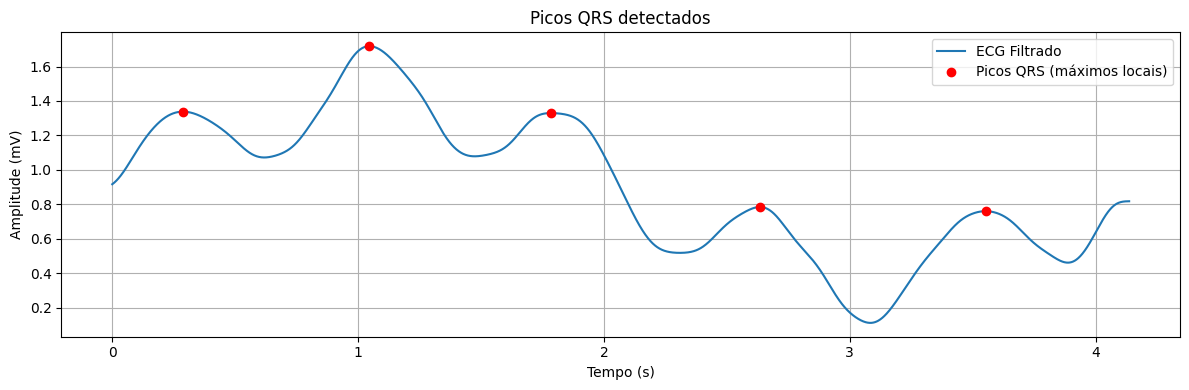

In [10]:
# Detectar picos onde o sinal sobe e depois desce
picos, _ = find_peaks(sinal_filtrado, distance=int(fs * 0.5), height=0.6)  # ajuste height conforme necessário

# Plotar
plt.figure(figsize=(12, 4))
plt.plot(tempo_s, sinal_filtrado, label='ECG Filtrado')
plt.plot(tempo_s[picos], sinal_filtrado[picos], 'ro', label='Picos QRS (máximos locais)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Picos QRS detectados')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Etapa 10 – Cálculo da Frequência Cardíaca e Variabilidade**
---
Calcula os intervalos RR (tempo entre batimentos), frequência cardíaca instantânea e média, e dois importantes índices de variabilidade da frequência cardíaca: SDNN (desvio padrão dos RR) e RMSSD (variação rápida entre batimentos).

In [11]:
# Calcular intervalos RR (em segundos)
intervalos_RR = np.diff(tempo_s[picos])  # tempo entre picos consecutivos

# Calcular frequência cardíaca instantânea (em bpm)
frequencias_bpm = 60 / intervalos_RR

# Média do intervalo RR e da frequência cardíaca
rr_medio = np.mean(intervalos_RR)
fc_media = np.mean(frequencias_bpm)

# Variabilidade: SDNN e RMSSD
sdnn = np.std(intervalos_RR)  # desvio padrão dos intervalos RR
rmssd = np.sqrt(np.mean(np.diff(intervalos_RR)**2))  # raiz do quadrado das diferenças sucessivas

# Exibir resultados
print(f"Intervalo RR médio: {rr_medio*1000:.2f} ms")
print(f"Frequência cardíaca média: {fc_media:.2f} bpm")
print(f"SDNN (desvio padrão dos RR): {sdnn*1000:.2f} ms")
print(f"RMSSD (variabilidade de batimentos): {rmssd*1000:.2f} ms")



Intervalo RR médio: 816.21 ms
Frequência cardíaca média: 74.08 bpm
SDNN (desvio padrão dos RR): 72.45 ms
RMSSD (variabilidade de batimentos): 75.84 ms
